In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))
from constants import *

def load_test(dataset, aspect):
    """Load data from the specified dataset and aspect."""
    file_path = f"../data/{dataset}/{dataset}_{aspect}_test_annotations.tsv"
    return pd.read_csv(file_path, sep='\t')

def load_train(dataset, aspect, db_version=None):
    """Load training data from the specified dataset, aspect, and SwissProt version."""
    if db_version is None:
        file_path = f"../data/{dataset}/{dataset}_{aspect}_train_annotations.tsv"
    else:
        # Like /home/atoffano/PFP_baselines/data/swissprot/2024_01/swissprot_2024_01_BPO_annotations.tsv
        file_path = f"../data/swissprot/{db_version}/swissprot_{db_version}_{aspect}_annotations.tsv"
    return pd.read_csv(file_path, sep='\t')

# GO Annotations per Protein of Test Datasets

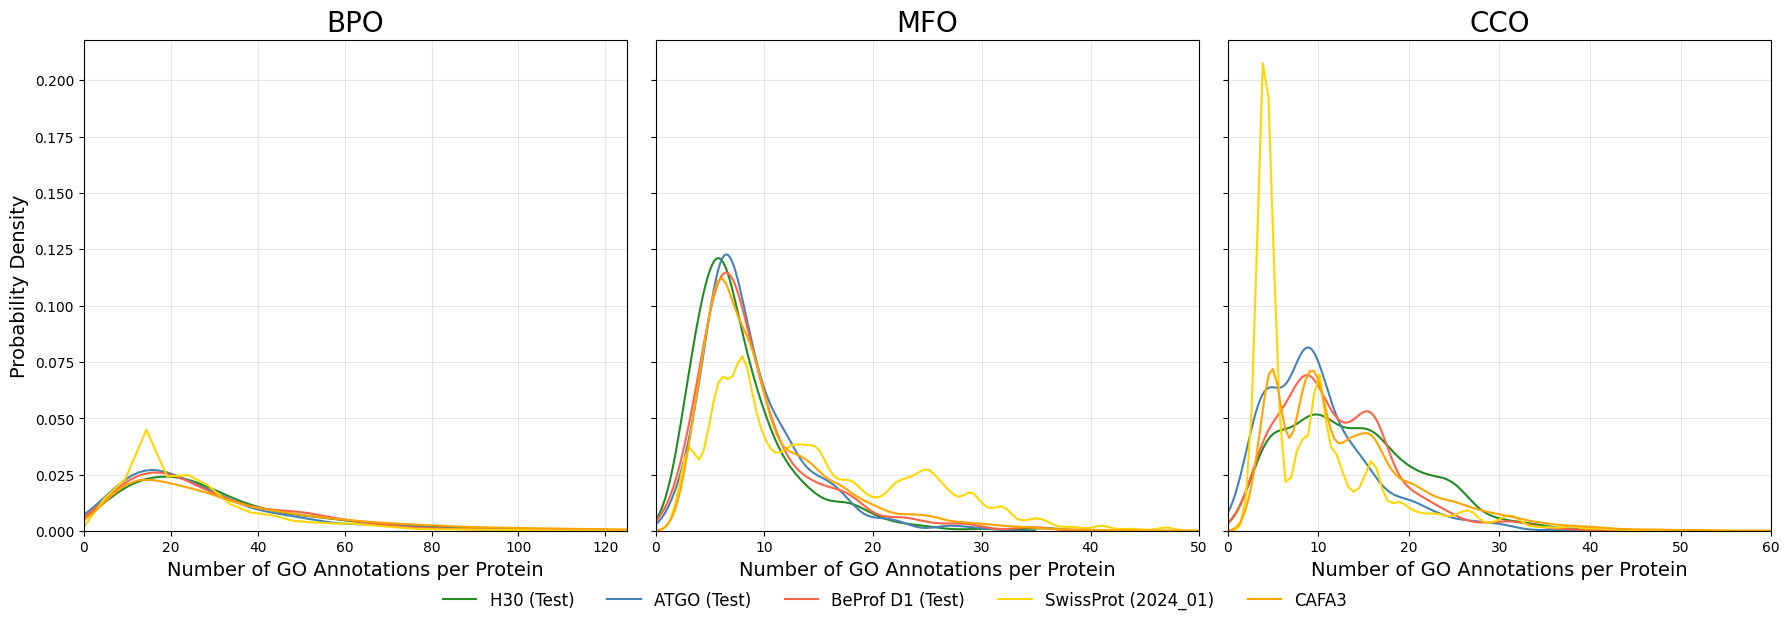

In [11]:
swissprot_test_color = 'forestgreen'  # SwissProt H30 (Test)
test_beprof_color = 'tomato'          # BeProf D1 (Test)
test_atgo_color = 'steelblue'         # ATGO (Test)
# Yellow but prettier
swissprot_ref_color = '#FFD700'  # SwissProt H30 (Reference)
test_cafa_color = 'orange'


fig, axs = plt.subplots(1, len(SUBONTOLOGIES), figsize=(18, 6), sharey=True)

if len(SUBONTOLOGIES) == 1:
    axs = [axs]

for col, aspect in enumerate(SUBONTOLOGIES):
    for dataset in ["H30", "ATGO", "D1", 'SwissProt', 'CAFA3']:
        # Load and process data
        if dataset not in ['SwissProt']:
            df = load_test(dataset, aspect)
        else:
            df = load_train(dataset, aspect, db_version='2024_01')
        df['term'] = df['term'].str.split('; ')
        df = df.explode('term')
        counts = df.groupby('EntryID')['term'].count().reset_index(name='annotation_count')

        # Determine color and label based on dataset
        match dataset:
            case 'H30':
                color = swissprot_test_color
                label = 'H30 (Test)'
            case 'ATGO':
                color = test_atgo_color
                label = 'ATGO (Test)'
            case 'D1':
                color = test_beprof_color
                label = 'BeProf D1 (Test)'
            case 'SwissProt':
                color = swissprot_ref_color
                label = 'SwissProt (2024_01)'
            case 'CAFA3':
                color = test_cafa_color
                label = 'CAFA3'

        ann_counts = counts['annotation_count'].clip(lower=0)

        sns.kdeplot(
            ann_counts, fill=False, alpha=1,
            color=color, label=label, common_norm=False, clip=(0, None), ax=axs[col]
        )

    # Xlim to 125 on BPO, 50 on MFO, 60 on CCO
    if aspect == 'BPO':
        axs[col].set_xlim(0, 125)
    elif aspect == 'MFO':
        axs[col].set_xlim(0, 50)
    elif aspect == 'CCO':
        axs[col].set_xlim(0, 60)

    axs[col].set_title(f"{aspect}", fontsize=20)
    axs[col].set_xlabel('Number of GO Annotations per Protein', fontsize=14)
    axs[col].grid(alpha=0.3)
    if col == 0:
        axs[col].set_ylabel('Probability Density', fontsize=14)

# Legend on the bottom, common for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=12, bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.tight_layout()
plt.show()

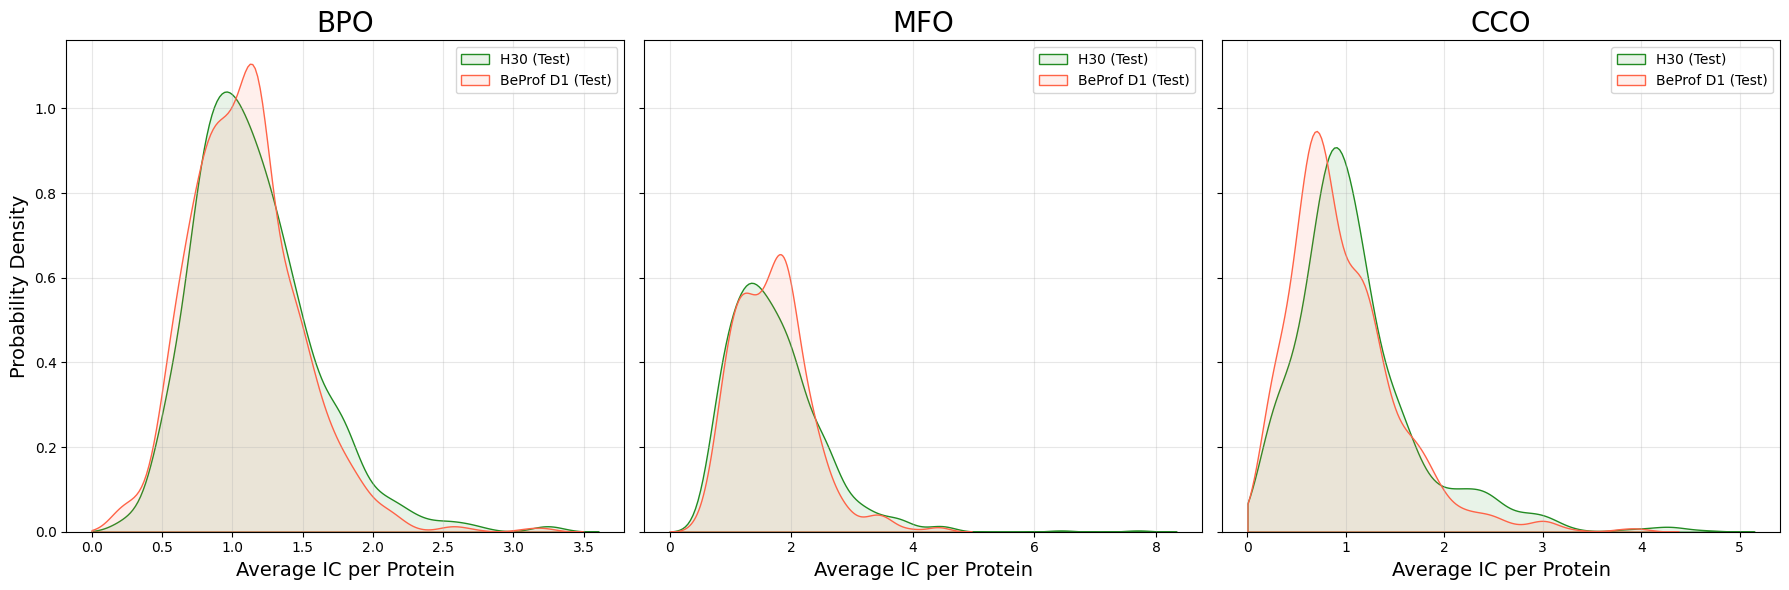

In [10]:
# Load IC values for each term (example for BPO, repeat for other aspects)
ic_files = {
    aspect: f"/home/atoffano/PFP_baselines/data/H30/IC_H30_{aspect}.tsv"
    for aspect in SUBONTOLOGIES
}
ic_dicts = {}
for aspect in SUBONTOLOGIES:
    ic_df = pd.read_csv(ic_files[aspect], sep='\t', names=['term', 'IC'])
    ic_dicts[aspect] = dict(zip(ic_df['term'], ic_df['IC']))

fig, axs = plt.subplots(1, len(SUBONTOLOGIES), figsize=(18, 6), sharey=True)

if len(SUBONTOLOGIES) == 1:
    axs = [axs]

for col, aspect in enumerate(SUBONTOLOGIES):
    ic_dict = ic_dicts[aspect]
    for dataset in ['H30', 'D1']:  # Exclude ATGO
        df = load_test(dataset, aspect)
        df['term'] = df['term'].str.split('; ')
        df = df.explode('term')
        # Map IC values
        df['IC'] = df['term'].map(ic_dict)
        avg_ic = df.groupby('EntryID')['IC'].mean().dropna()

        # Determine color and label based on dataset
        match dataset:
            case 'H30':
                color = swissprot_test_color
                label = 'H30 (Test)'
            case 'D1':
                color = test_beprof_color
                label = 'BeProf D1 (Test)'

        sns.kdeplot(
            avg_ic, fill=True, alpha=0.1,
            color=color, label=label, common_norm=False, clip=(0, None), ax=axs[col]
        )

    axs[col].set_title(f"{aspect}", fontsize=20)
    axs[col].set_xlabel('Average IC per Protein', fontsize=14)
    axs[col].grid(alpha=0.3)
    axs[col].legend(fontsize=10)
    if col == 0:
        axs[col].set_ylabel('Probability Density', fontsize=14)

plt.tight_layout()
plt.show()

/home/atoffano/miniconda3/envs/pfp_baselines/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/atoffano/miniconda3/envs/pfp_baselines/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


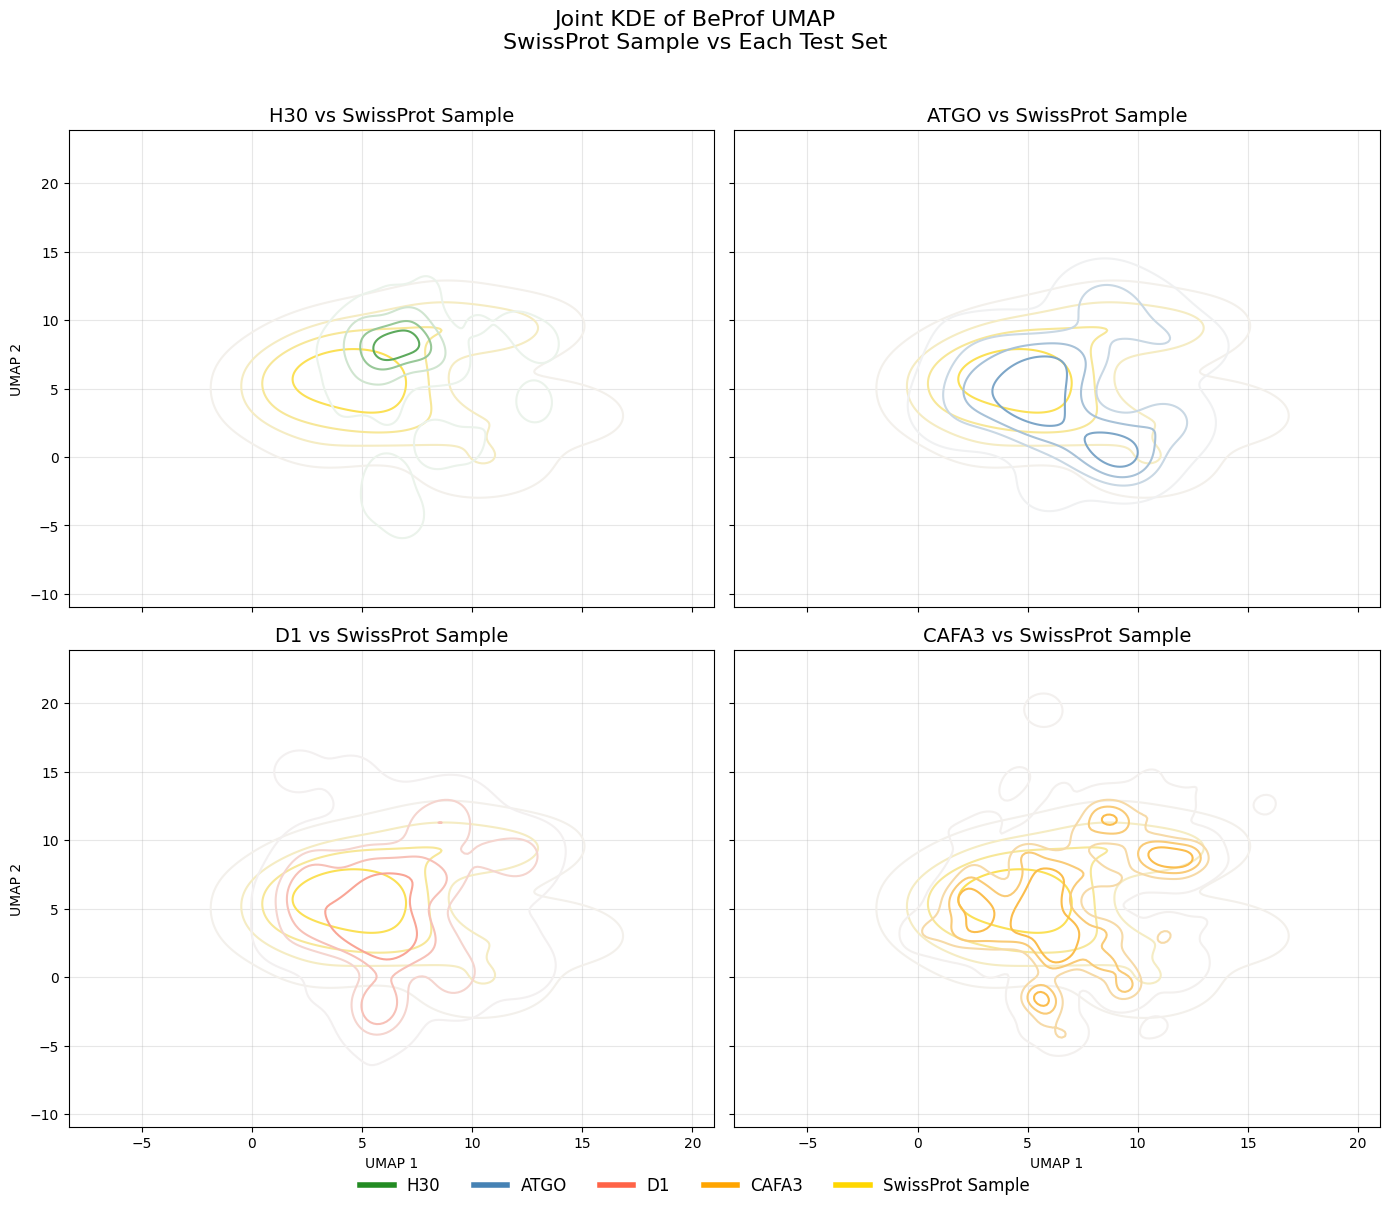

In [ ]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- Color definitions ---
swissprot_test_color = 'forestgreen'  # SwissProt H30 (Test)
test_atgo_color = 'steelblue'         # ATGO (Test)
test_beprof_color = 'tomato'          # D1 (Test)
test_cafa_color = 'orange'            # CAFA3 (Test)
swissprot_sample_color = 'gold'
dataset_colors = {
    'H30': swissprot_test_color,
    'ATGO': test_atgo_color,
    'D1': test_beprof_color,
    'CAFA3': test_cafa_color,
    'SwissProt Sample': swissprot_sample_color
}

# --- Load SwissProt mapping ---
id_mapping = pd.read_csv(
    f"../data/swissprot/2024_01/swissprot_2024_01_annotations.tsv",
    sep="\t",
    usecols=["EntryID", "Entry Name"],
)
id_mapping = id_mapping.set_index("Entry Name").to_dict()["EntryID"]

# --- Load all test proteins for each dataset ---
def get_test_proteins(dataset, subontologies, id_mapping, prefix=None):
    proteins = set()
    for aspect in subontologies:
        if prefix:
            path = f'/home/atoffano/PFP_baselines/data/{prefix}/{prefix}_{aspect}_test_annotations.tsv'
        else:
            path = f'/home/atoffano/PFP_baselines/data/{dataset}/{dataset}_{aspect}_test_annotations.tsv'
        df = pd.read_csv(path, sep='\t')
        proteins.update(df['EntryID'].unique())
    # Apply mapping
    proteins = {id_mapping.get(p, p) for p in proteins}
    return proteins

subontologies = ['BPO', 'MFO', 'CCO']

h30_test_proteins = get_test_proteins('H30', subontologies, id_mapping, prefix='H30')
atgo_test_proteins = get_test_proteins('ATGO', subontologies, id_mapping)
d1_test_proteins = get_test_proteins('D1', subontologies, id_mapping)
cafa3_test_proteins = get_test_proteins('CAFA3', subontologies, id_mapping)

# --- Load all SwissProt proteins from the unified SwissProt annotation file (all proteins, all subontologies) ---
swissprot_df = pd.read_csv('/home/atoffano/PFP_baselines/data/swissprot/2024_01/swissprot_2024_01_annotations.tsv', sep='\t')
swissprot_proteins = set(swissprot_df['EntryID'].unique())

# Optionally, sample a subset of SwissProt for visualization clarity
swissprot_sample = set(pd.Series(list(swissprot_proteins)).sample(n=5000, random_state=42))

# --- Merge all proteins for embedding selection ---
selected_proteins = h30_test_proteins | atgo_test_proteins | d1_test_proteins | cafa3_test_proteins | swissprot_sample

# --- Load embeddings ---
emb_df = pd.read_csv('/home/atoffano/these-antoine/data/BeProf/beprof_esmc_600M_emb.csv')
emb_df = emb_df[emb_df['protein'].isin(selected_proteins)].reset_index(drop=True)
embedding_cols = [col for col in emb_df.columns if col != 'protein']

# --- UMAP ---
umap_emb = umap.UMAP(random_state=42).fit_transform(emb_df[embedding_cols])

# --- Assign group labels ---
protein_set = []
for p in emb_df['protein']:
    if p in h30_test_proteins:
        protein_set.append('H30')
    elif p in atgo_test_proteins:
        protein_set.append('ATGO')
    elif p in d1_test_proteins:
        protein_set.append('D1')
    elif p in cafa3_test_proteins:
        protein_set.append('CAFA3')
    elif p in swissprot_sample:
        protein_set.append('SwissProt Sample')
    else:
        protein_set.append('Other')

colors = [dataset_colors.get(c, 'gray') for c in protein_set]

umap_df = pd.DataFrame({
    'UMAP1': umap_emb[:, 0],
    'UMAP2': umap_emb[:, 1],
    'Group': protein_set
})

datasets = ['H30', 'ATGO', 'D1', 'CAFA3']
groups_to_plot = ['SwissProt Sample']  # Always include SwissProt Sample

fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    # Only plot SwissProt Sample and the current dataset
    plot_groups = groups_to_plot + [dataset]
    for group in plot_groups:
        color = dataset_colors[group]
        subset = umap_df[umap_df['Group'] == group]
        if len(subset) > 1:
            sns.kdeplot(
                x=subset['UMAP1'],
                y=subset['UMAP2'],
                fill=False,
                thresh=0.05,
                levels=5,
                cmap=sns.light_palette(color, as_cmap=True),
                alpha=1,
                label=group,
                ax=ax
            )
    ax.set_title(f"{dataset} vs SwissProt Sample", fontsize=14)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(alpha=0.3)

# Add dataset colors legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in dataset_colors.values()]
labels = list(dataset_colors.keys())
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=12, bbox_to_anchor=(0.5, -0.02), frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
def load_exp_ground_truth(dataset, subontology, version=None):
    """
    Load ground truth TSV file for a given dataset, subontology, and SwissProt version.

    Args:
        dataset: Dataset name (e.g., 'ATGO')
        subontology: Subontology (e.g., 'BPO', 'MFO', 'CCO')
        version: SwissProt version (e.g., '2024_01')
    Returns:
        pandas.DataFrame: Ground truth dataframe
    """
    if dataset == 'swissprot':
        gt_path = f"../data/swissprot/{version}/swissprot_{version}_{subontology}_exp_annotations.tsv"
    else:
        gt_path = f"../data/{dataset}/{dataset}_{subontology}_test_annotations.tsv"
    gt = pd.read_csv(gt_path, sep='\t')
    gt['term'] = gt['term'].str.split('; ')
    gt = gt.explode('term')
    return gt

def load_ground_truth(dataset, subontology, version=None):
    """
    Load ground truth TSV file for a given dataset, subontology, and SwissProt version.

    Args:
        dataset: Dataset name (e.g., 'ATGO')
        subontology: Subontology (e.g., 'BPO', 'MFO', 'CCO')
      <<<<<<
        version: SwissProt version (e.g., '2024_01')
    Returns:
        pandas.DataFrame: Ground truth dataframe
    """
    if dataset == 'swissprot':
        gt_path = f"../data/swissprot/{version}/swissprot_{version}_{subontology}_annotations.tsv"
    else:
        gt_path = f"../data/{dataset}/{dataset}_{subontology}_test_annotations.tsv"
    gt = pd.read_csv(gt_path, sep='\t')
    gt['term'] = gt['term'].str.split('; ')
    gt = gt.explode('term')
    return gt

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

uniprot_mapping = pd.read_csv(
    f"../data/swissprot/2024_01/swissprot_2024_01_annotations.tsv",  # Most up to date mapping
    sep="\t",
    usecols=["EntryID", "Entry Name"],
)
uniprot_mapping = uniprot_mapping.set_index("Entry Name").to_dict()["EntryID"]


Subontology: BPO
Sampled Term-level Mean Jaccard Scores: [0.1773871119473189, 0.23505203127755894, 0.2707451810061119, 0.34914577584688544, 0.39439098803097866, 0.49184559427431657, 0.5527287648748461, 0.6333196745302347, 0.7023057116104869, 0.7591151167554281, 0.8032767700409597, 0.8579362759427068, 0.9193350114148569, 0.9598400658552361, 1.0, 0.9793748916748513, 0.965694388949141, 0.9534529451591063, 0.9395868230039084, 0.9277814642778146, 0.9147474303303469]
Sampled Term-level Median Jaccard Scores: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.11538461538461539), np.float64(0.2692307692307692), np.float64(0.48148148148148145), np.float64(0.6923076923076923), np.float64(0.8367346938775511), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
Sampled Term-level Q1 Jaccard Scores: [np.float64(0.0), n

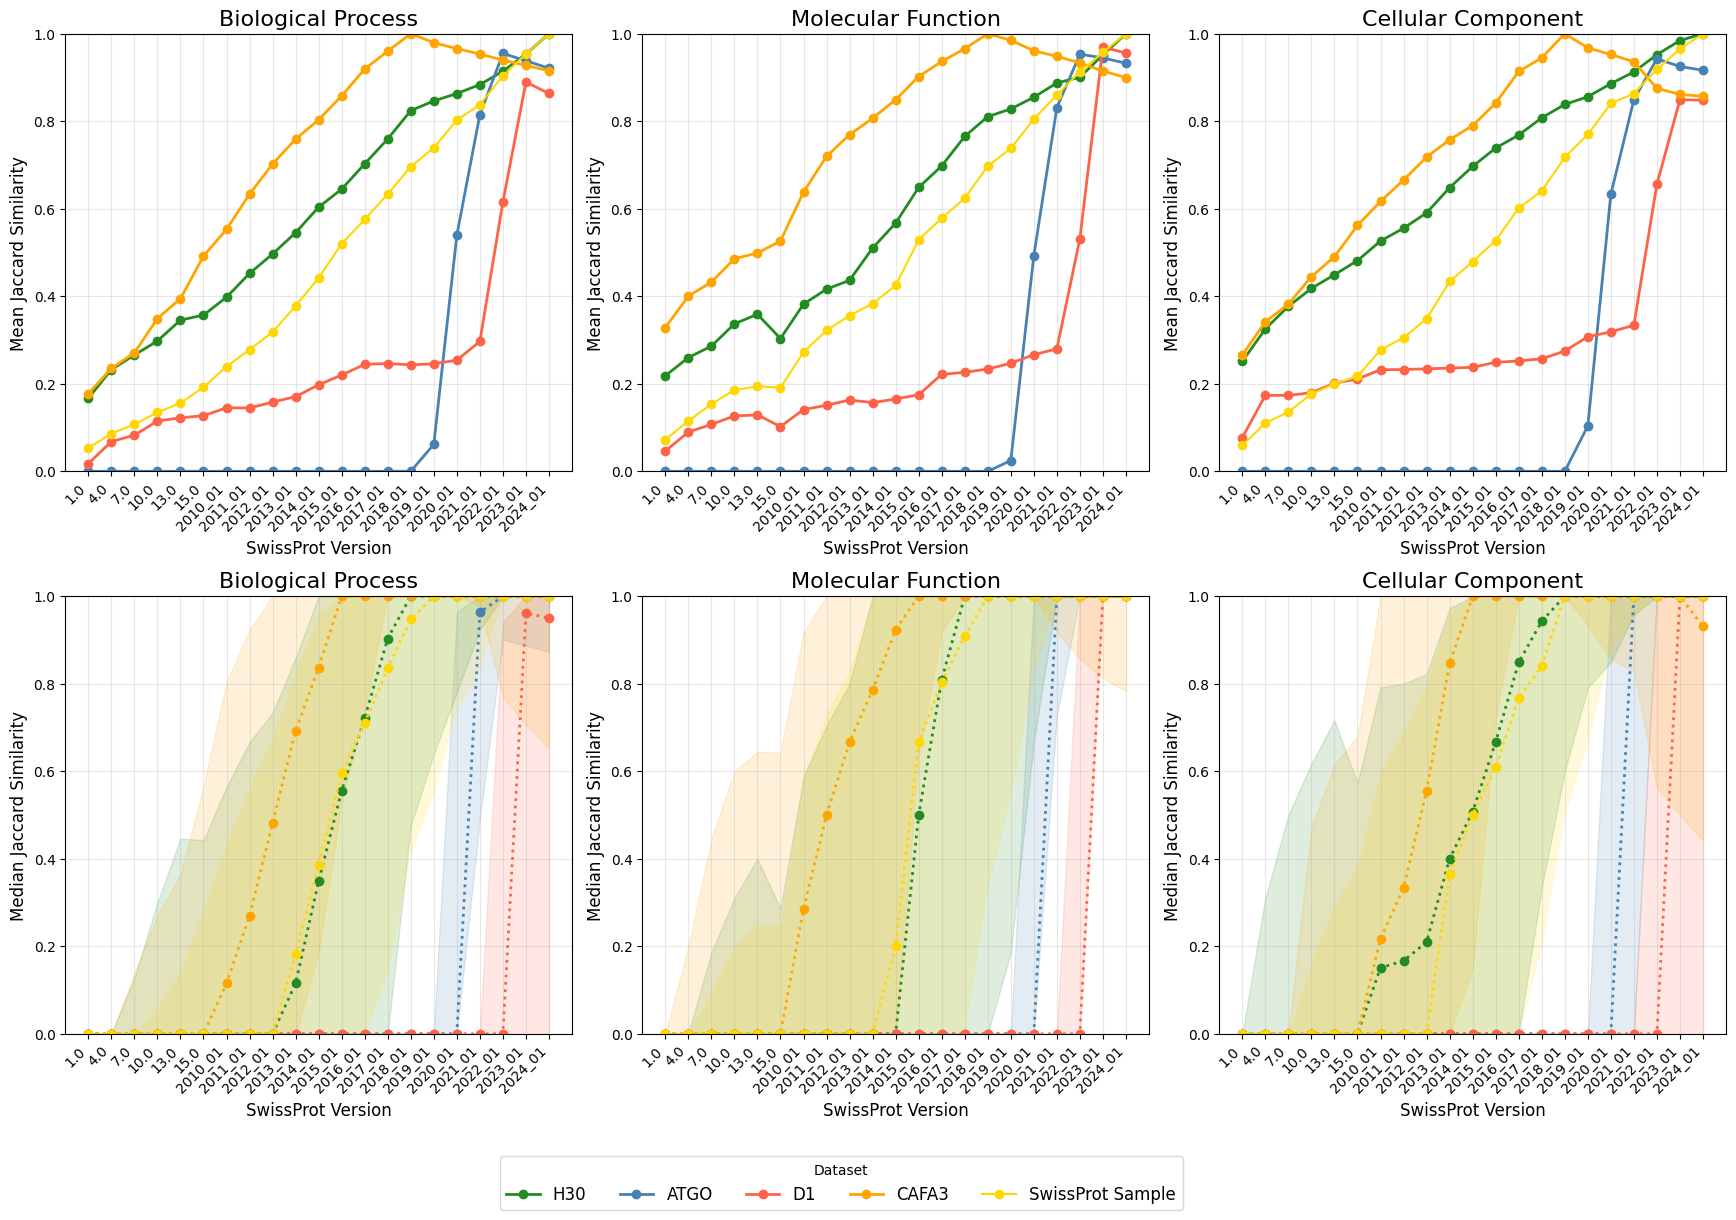

In [9]:
import random

import numpy as np
from scipy.stats import linregress

# Helper to get version indices
def get_version_indices(versions, start, end):
    """Return indices for versions between start and end (inclusive)."""
    idx_start = None
    idx_end = None
    for i, v in enumerate(versions):
        if v == start:
            idx_start = i
        if v == end:
            idx_end = i
    if idx_start is not None and idx_end is not None:
        return idx_start, idx_end
    return None, None
regression_results = {}

# Create subplots with 2 rows
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Colors for datasets
swissprot_test_color = 'forestgreen'  # SwissProt H30 (Test)
test_atgo_color = 'steelblue'         # ATGO (Test)
test_beprof_color = 'tomato'
test_cafa_color = 'orange'
swissprot_sample_color = 'gold'
dataset_colors = {'H30': swissprot_test_color, 'ATGO': test_atgo_color, 'D1': test_beprof_color, 'CAFA3': test_cafa_color, 'SwissProt Sample': swissprot_sample_color}

all_handles = []
all_labels = []

for col, subontology in enumerate(SUBONTOLOGIES):
    # Initialize storage for both mean/median plots
    dataset_stats = {dataset: {"mean": [], "median": [], "q1": [], "q3": [], "versions": []} for dataset in DATASETS}
    
    # Process each dataset
    for dataset in DATASETS:
        # Load base ground truth for the dataset
        base_gt = load_exp_ground_truth(dataset, subontology)
        base_proteins = set(base_gt['EntryID'].unique())
        base_terms = set(base_gt['term'].unique())
        
        # Pre-create protein-to-terms mapping for base dataset
        base_protein_terms = base_gt.groupby('EntryID')['term'].apply(set).to_dict()
        
        for version in SWISSPROT_VERSIONS:
            try:
                # Load SwissProt ground truth for this version
                swissprot_gt = load_exp_ground_truth('swissprot', subontology, version)
                
                # Apply mapping if needed
                if dataset not in ['ATGO', 'H30']:
                    swissprot_gt['EntryID'] = swissprot_gt['EntryID'].map(uniprot_mapping)
                
                # Restrict to proteins that exist in the dataset's ground truth
                swissprot_gt_filtered = swissprot_gt[swissprot_gt['EntryID'].isin(base_proteins)]
                swissprot_terms = set(swissprot_gt_filtered['term'].unique())
                
                # Calculate term-level Jaccard similarity
                jaccard_score = jaccard_similarity(base_terms, swissprot_terms)
                
                # Calculate per-protein Jaccard similarities for statistics
                swissprot_protein_terms = swissprot_gt_filtered.groupby('EntryID')['term'].apply(set).to_dict()
                jaccard = []
                
                for protein in base_proteins:
                    base_protein_terms_set = base_protein_terms.get(protein, set())
                    swissprot_protein_terms_set = swissprot_protein_terms.get(protein, set())
                    score = jaccard_similarity(base_protein_terms_set, swissprot_protein_terms_set)
                    jaccard.append(score)
                
                if jaccard:
                    # Store both term-level and protein-level statistics
                    dataset_stats[dataset]["mean"].append(jaccard_score)  # Term-level for top plot
                    dataset_stats[dataset]["median"].append(np.median(jaccard))
                    dataset_stats[dataset]["q1"].append(np.percentile(jaccard, 25))
                    dataset_stats[dataset]["q3"].append(np.percentile(jaccard, 75))
                    dataset_stats[dataset]["versions"].append(version)
                
            except FileNotFoundError:
                continue
        if dataset == 'CAFA3':
            print(f"Subontology: {subontology}")
            print(f"Sampled Term-level Mean Jaccard Scores: {dataset_stats[dataset]['mean']}")
            print(f"Sampled Term-level Median Jaccard Scores: {dataset_stats[dataset]['median']}")
            print(f"Sampled Term-level Q1 Jaccard Scores: {dataset_stats[dataset]['q1']}")
            print(f"Sampled Term-level Q3 Jaccard Scores: {dataset_stats[dataset]['q3']}")

    
    # Plot term-level Jaccard similarity (top row)
    for dataset in DATASETS:
        versions = dataset_stats[dataset]["versions"]
        means = dataset_stats[dataset]["mean"]
        color = dataset_colors[dataset]
        
        h, = axs[0, col].plot(versions, means, 
                             marker='o', label=dataset, color=color, linewidth=2)
        if col == 0:
            all_handles.append(h)
            all_labels.append(dataset)
    
    # Plot per-protein statistics (bottom row)
    for dataset in DATASETS:
        versions = dataset_stats[dataset]["versions"]
        median = dataset_stats[dataset]["median"]
        q1 = dataset_stats[dataset]["q1"]
        q3 = dataset_stats[dataset]["q3"]
        color = dataset_colors[dataset]
        
        h_median, = axs[1, col].plot(versions, median, marker='o', linestyle=':', 
                                    label=f"{dataset}", color=color, linewidth=2)
        axs[1, col].fill_between(versions, q1, q3, color=color, alpha=0.15)
    
    # Add SwissProt sample for both plots
    swissprot_2024 = load_exp_ground_truth('swissprot', subontology, version='2024_01')
    all_proteins = list(swissprot_2024['EntryID'].unique())
    all_terms = set(swissprot_2024['term'].unique())
    sampled_proteins = set(random.sample(all_proteins, 5000))
    
    # Pre-create protein-to-terms mapping for 2024 sample
    swissprot_2024_sampled = swissprot_2024[swissprot_2024['EntryID'].isin(sampled_proteins)]
    swissprot_2024_protein_terms = swissprot_2024_sampled.groupby('EntryID')['term'].apply(set).to_dict()
    
    sample_term_scores = []
    sample_protein_medians = []
    sample_protein_q1 = []
    sample_protein_q3 = []
    sample_versions = []
    
    for version in SWISSPROT_VERSIONS:
        try:
            gt = load_exp_ground_truth('swissprot', subontology, version=version)
            gt_sampled = gt[gt['EntryID'].isin(sampled_proteins)]
            gt_protein_terms = gt_sampled.groupby('EntryID')['term'].apply(set).to_dict()
            jaccard = []
            for protein in sampled_proteins:
                terms_2024 = swissprot_2024_protein_terms.get(protein, set())
                terms_version = gt_protein_terms.get(protein, set())
                score = jaccard_similarity(terms_2024, terms_version)
                jaccard.append(score)
            if jaccard:
                sample_term_scores.append(np.mean(jaccard))
                sample_protein_medians.append(np.median(jaccard))
                sample_protein_q1.append(np.percentile(jaccard, 25))
                sample_protein_q3.append(np.percentile(jaccard, 75))
                sample_versions.append(version)
        except FileNotFoundError:
            continue

    print(f"SWISSPROT;\nSubontology: {subontology}")
    print(f"Sampled Term-level Mean Jaccard Scores: {sample_term_scores}")
    print(f"Sampled Term-level Median Jaccard Scores: {sample_protein_medians}")
    print(f"Sampled Term-level Q1 Jaccard Scores: {sample_protein_q1}")
    print(f"Sampled Term-level Q3 Jaccard Scores: {sample_protein_q3}")

    # Plot SwissProt sample - top row (term-level)
    h_sample, = axs[0, col].plot(sample_versions, sample_term_scores, 
                                marker='o', color=swissprot_sample_color, 
                                label='SwissProt Sample')
    if col == 0:
        all_handles.append(h_sample)
        all_labels.append('SwissProt Sample')
    
    # Plot SwissProt sample - bottom row (per-protein)
    h_sample_median, = axs[1, col].plot(sample_versions, sample_protein_medians, 
                                       marker='o', linestyle=':', 
                                       label="SwissProt Sample", 
                                       color=swissprot_sample_color, linewidth=2)
    axs[1, col].fill_between(sample_versions, sample_protein_q1, sample_protein_q3, 
                            color=swissprot_sample_color, alpha=0.15, linewidth=0)
    
    # Configure top row (term-level Jaccard)
    axs[0, col].set_title(f"{SUBONTOLOGIES_LABELS[subontology]}", fontsize=16)
    axs[0, col].set_xlabel('SwissProt Version', fontsize=12)
    axs[0, col].set_ylabel('Mean Jaccard Similarity', fontsize=12)
    axs[0, col].set_xticks(range(len(sample_versions)))
    axs[0, col].set_xticklabels(sample_versions, rotation=45, ha='right')
    axs[0, col].grid(alpha=0.3)
    axs[0, col].set_ylim(0, 1)
    
    # Configure bottom row (per-protein statistics)
    axs[1, col].set_title(f"{SUBONTOLOGIES_LABELS[subontology]}", fontsize=16)
    axs[1, col].set_xlabel('SwissProt Version', fontsize=12)
    axs[1, col].set_ylabel('Median Jaccard Similarity', fontsize=12)
    axs[1, col].set_xticks(range(len(sample_versions)))
    axs[1, col].set_xticklabels(sample_versions, rotation=45, ha='right')
    axs[1, col].grid(alpha=0.3)
    axs[1, col].set_ylim(0, 1)


    # --- Linear regression for CAFA3 ---
    versions = dataset_stats['CAFA3']["versions"]
    means = dataset_stats['CAFA3']["mean"]
    if versions and means:
        # Find indices for 1.0 and 2018_01
        idx_1_0, idx_2018_01 = get_version_indices(versions, "1.0", "2018_01")
        if idx_1_0 is not None and idx_2018_01 is not None:
            # Regression from 1.0 to 2018_01 (inclusive)
            x1 = np.arange(idx_1_0, idx_2018_01 + 1)
            y1 = np.array(means[idx_1_0:idx_2018_01 + 1])
            slope1, _, _, _, _ = linregress(x1, y1)
            # Regression from 2018_01 to last (inclusive)
            x2 = np.arange(idx_2018_01, len(versions))
            y2 = np.array(means[idx_2018_01:])
            slope2, _, _, _, _ = linregress(x2, y2)
            regression_results[f"CAFA3_{subontology}_1.0-2018_01"] = slope1
            regression_results[f"CAFA3_{subontology}_2018_01-2024_01"] = slope2

    # --- Linear regression for H30 ---
    versions = dataset_stats['H30']["versions"]
    means = dataset_stats['H30']["mean"]
    if versions and means:
        x = np.arange(len(versions))
        y = np.array(means)
        slope, _, _, _, _ = linregress(x, y)
        regression_results[f"H30_{subontology}_all"] = slope

    # --- Linear regression for SwissProt Sample ---
    versions = sample_versions
    means = sample_term_scores
    if versions and means:
        x = np.arange(len(versions))
        y = np.array(means)
        slope, _, _, _, _ = linregress(x, y)
        regression_results[f"SwissProtSample_{subontology}_all"] = slope

# Print regression coefficients
print("Regression coefficients (slopes):")
for k, v in regression_results.items():
    print(f"{k}: {v:.10f}")


# Add legends
fig.legend(all_handles, all_labels, loc='lower center', ncol=len(DATASETS)+1, 
          fontsize=12, title="Dataset", bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0.03, 0.05, 1, 1])
plt.show()